# Evaluation Of Duet Benchmarking Results from Distributed Database "Cassandra"

### Imports

In [190]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
from pathlib import Path

### Import Benchmarking Measurements as csv file and create Pandas Dataframe for further Analysis

In [191]:
cwd = Path.cwd()
filepath = os.path.join(cwd, "Results", "1mCops_3t", "AA", "load_measurements1.csv")
print(filepath)
df = pd.read_csv(filepath)

C:\Users\Felix Medicus\Desktop\Thesis_MCC\DuetBenchmarking\Results\Results\1mCops_3t\AA\load_measurements1.csv


### Insert latencies in ms into the measurement table

In [192]:
df["latency_ms"] = (df["received"]- df["sent"])/1000000

In [193]:
df["sent_ms"] = df["sent"].div(1000000)
df["received_ms"] = df["received"].div(1000000)

In [194]:
df.describe()

,sent,received,latency_ms,sent_ms,received_ms
count,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
mean,1.244700e+12,1.244710e+12,9.677485e+00,1.244700e+06,1.244710e+06
std,3.317779e+11,3.317782e+11,2.809713e+01,3.317779e+05,3.317782e+05
min,7.138860e+11,7.139794e+11,6.094180e-01,7.138860e+05,7.139794e+05
25%,9.352365e+11,9.353175e+11,1.480934e+00,9.352365e+05,9.353175e+05
50%,1.246099e+12,1.246111e+12,2.532188e+00,1.246099e+06,1.246111e+06
75%,1.538468e+12,1.538473e+12,4.967014e+00,1.538468e+06,1.538473e+06
max,1.815078e+12,1.815080e+12,1.139651e+03,1.815078e+06,1.815080e+06


### Restructure Timeline

In [195]:
firstSent = df["sent"].min()
df["sent_sec"] = (df["sent"] - firstSent)/1000000/1000

### Create Function to prune Measurements

In [196]:
def pruneMeasurements(dataframe): 
    print("Hello from the other side")
    
pruneMeasurements(df)


Hello from the other side


### Create subsets of dataframe (for Version A and B, and for each worker for Version A and B) 

In [197]:
dfA1 = df.loc[(df["workerId"] == "w1-vA")]
dfA2 = df.loc[(df["workerId"] == "w2-vA")]
dfA3 = df.loc[(df["workerId"] == "w3-vA")]
dfB1 = df.loc[(df["workerId"] == "w1-vB")]
dfB2 = df.loc[(df["workerId"] == "w2-vB")]
dfB3 = df.loc[(df["workerId"] == "w3-vB")]
dfA = df.loc[(df["workerId"] == "w1-vA") | (df["workerId"] == "w2-vA") | (df["workerId"] == "w3-vA")]
dfB = df.loc[(df["workerId"] == "w1-vB") | (df["workerId"] == "w2-vB") | (df["workerId"] == "w3-vB")]

### Return benchmark run time (First request send to last response received)

In [198]:
totalTime = df["received"].max() - df["sent"].min()
print(totalTime/1000000/1000/60, "minuten")

18.35322682205 minuten


In [199]:
dfA.describe()

,sent,received,latency_ms,sent_ms,received_ms,sent_sec
count,1.000000e+06,1.000000e+06,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000
mean,1.254351e+12,1.254361e+12,9.774248,1.254351e+06,1.254361e+06,540.465100
std,3.357173e+11,3.357175e+11,28.299411,3.357173e+05,3.357175e+05,335.717253
min,7.138910e+11,7.139794e+11,0.609418,7.138910e+05,7.139794e+05,0.005072
25%,9.438365e+11,9.438443e+11,1.503700,9.438365e+05,9.438443e+05,229.950502
50%,1.258181e+12,1.258189e+12,2.563613,1.258181e+06,1.258189e+06,544.295208
75%,1.553419e+12,1.553421e+12,5.040265,1.553419e+06,1.553421e+06,839.532902
max,1.815078e+12,1.815080e+12,944.048282,1.815078e+06,1.815080e+06,1101.192524


In [200]:
dfB.describe()

,sent,received,latency_ms,sent_ms,received_ms,sent_sec
count,1.000000e+06,1.000000e+06,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000
mean,1.235049e+12,1.235059e+12,9.580722,1.235049e+06,1.235059e+06,521.163145
std,3.275071e+11,3.275076e+11,27.893059,3.275071e+05,3.275076e+05,327.507138
min,7.138860e+11,7.139936e+11,0.610209,7.138860e+05,7.139936e+05,0.000000
25%,9.273257e+11,9.273285e+11,1.458987,9.273257e+05,9.273285e+05,213.439693
50%,1.230681e+12,1.230685e+12,2.500249,1.230681e+06,1.230685e+06,516.795338
75%,1.525675e+12,1.525682e+12,4.892151,1.525675e+06,1.525682e+06,811.788579
max,1.801378e+12,1.801379e+12,1139.650844,1.801378e+06,1.801379e+06,1087.492329


### Min. Latencies for Worker 2 (A & B)

In [201]:
dfA3.loc[dfA3["latency_ms"].idxmin()]

workerId                                        w3-vA
queryType                                      INSERT
queryId          607a0bfc-1aff-4aff-8d81-6789d4e0d2f8
sent                                    1653218593775
received                                1653219257080
target-region                                 unknown
latency_ms                                   0.663305
sent_ms                                1653218.593775
received_ms                             1653219.25708
sent_sec                                   939.332631
Name: 1900856, dtype: object

In [202]:
dfB1.loc[dfB1["latency_ms"].idxmin()]

workerId                                        w1-vB
queryType                                      INSERT
queryId          8a71a156-531d-4056-a385-ad4f3b0e471b
sent                                     949382992775
received                                 949383602984
target-region                                 unknown
latency_ms                                   0.610209
sent_ms                                 949382.992775
received_ms                             949383.602984
sent_sec                                    235.49703
Name: 175958, dtype: object

### Some checks

#### Time difference in ms when first query was sent by worker-1 to Version A and B 

In [203]:

dfA2["sent"].min() - dfB2["sent"].min()

-4263360

#### Time difference in ms when last query was sent by worker-1 to Version A and B 

In [204]:
dfA1["sent"].max() - dfB1["sent"].max() 


25976630330

## Create Figures 

### Create Boxplots

In [205]:
sns.set_theme(style="darkgrid")

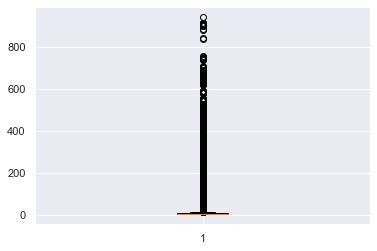

In [206]:
ax = plt.boxplot(x=dfA["latency_ms"])


### Create Flowchart

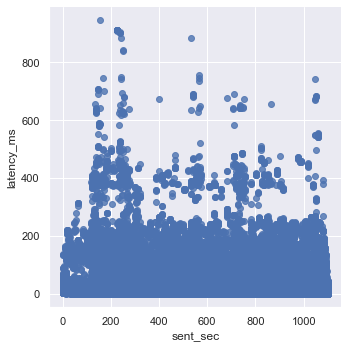

In [207]:
sns.lmplot(x='sent_sec', y='latency_ms', data=dfA, fit_reg=False)

In [213]:
latenciesA = dfA["latency_ms"].to_numpy()
latenciesB = dfB["latency_ms"].to_numpy()

<AxesSubplot:xlabel='sent_sec'>

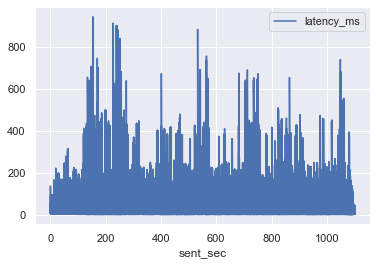

In [214]:
dfA.plot(x='sent_sec', y='latency_ms')

<AxesSubplot:xlabel='sent_sec'>

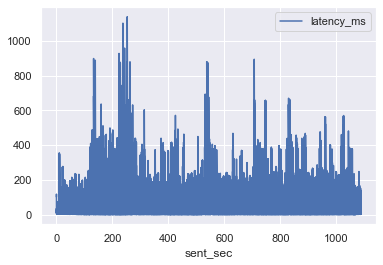

In [215]:
dfB.plot(x='sent_sec', y='latency_ms')